#README

In [ ]:
## You can simply click run all and everything
#  should work fine.
#
#  Also, if you want to run my code from top to end
#  you probably need this:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''
#  Just open <inspect> of the colab page and enter this function to
#  the <console> and it will help you to reconncect even your
#  session considered idle by google (while training especially).

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1-Q1krEw3581Fbocob-KT9DPvKuw0982V'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

id='1gxFmj_5Wtqy63x0yjcfDr6nhVAOPnkGO'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('val.csv')

id='1x9l7tCAVxMlH8s0o1smpcsbNTkMpPqMI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')

In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
df_val = pd.read_csv('val.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding = "ISO-8859-1")
df_train.head(10)

,Sentence,NER
0,-docstart-,O
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O
2,peter blackburn,I-PER I-PER
3,brussels 1996-08-22,I-LOC O
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...
5,germany 's representative to the european unio...,I-LOC O O O O I-ORG I-ORG O O O I-PER I-PER O ...
6,""" we do n't support any such recommendation be...",O O O O O O O O O O O O O O O O O O O O I-ORG ...
7,he said further scientific study was required ...,O O O O O O O O O O O O O O O O O O O O O O I-...
8,he said a proposal last month by eu farm commi...,O O O O O O O I-ORG O O I-PER I-PER O O O O O ...
9,fischler proposed eu-wide measures after repor...,I-PER O I-MISC O O O O I-LOC O I-LOC O O O O O...


In [ ]:
df_test.head()

,Sentence,NER
0,-docstart-,NaN
1,"soccer - japan get lucky win , china in surpri...",NaN
2,nadim ladki,NaN
3,"al-ain , united arab emirates 1996-12-06",NaN
4,japan began the defence of their asian cup tit...,NaN


In [ ]:
## Checking if there's any null values in dataset.
#  Considering statements posted, there's no need 
#  for further preprocessing.
#------------------------------------------------

from collections import Counter
print('Nan in Train: ', Counter(df_train['Sentence'].isnull().values))
print('Nan in Validation: ', Counter(df_val['Sentence'].isnull().values))
print('Nan in Test: ', Counter(df_test['Sentence'].isnull().values))

print('Nan in Train: ', Counter(df_train['NER'].isnull().values))
print('Nan in Validation: ', Counter(df_val['NER'].isnull().values))
print('Nan in Test: ', Counter(df_test['NER'].isnull().values))

Nan in Train:  Counter({False: 3000})
Nan in Validation:  Counter({False: 700})
Nan in Test:  Counter({False: 3684})
Nan in Train:  Counter({False: 3000})
Nan in Validation:  Counter({False: 700})
Nan in Test:  Counter({True: 3684})


#Section 1 Baseline Implementation

In [ ]:
## To accelerate training by loading data in parallel.
#  Well, as I set number of workers to 4, I thought it
#  should accelerate data loading by 4 times since 4
#  sets of data of batch size 1 should be loaded each
#  time. But the final time cost was not improved.
#
#  As there's no differences, I kept using DataLoaders
#  for later conveniences.
#-------------------------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sent = self.df['Sentence'].iloc[idx].split(' ')
        target = self.df['NER'].iloc[idx].split(' ')
               
        return sent, target

class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sent = self.df['Sentence'].iloc[idx].split(' ')
        return sent
    
def collate_fn(batch):
    sent, target = zip(*batch)
    sent_index = [torch.tensor(to_index(sent_i, word_to_ix),\
                               dtype=torch.long) for sent_i in sent]
    target_index = [torch.tensor(to_index(target_i, tag_to_ix),\
                                 dtype=torch.long) for target_i in target]
    
    return sent_index, target_index

def to_index(data, to_ix):
    input_index_list = []
    for w in data:
        input_index_list.append(to_ix[w])
    return input_index_list

ds_train = TrainDataset(df_train)
ds_val = TrainDataset(df_val)
ds_test = TestDataset(df_test)

In [ ]:
## Prepare for word embeddings
word_to_ix = {}
for sentence,_ in ds_train+ds_val:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

for sentence in ds_test:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

word_to_ix['<P>'] = len(word_to_ix)

## Prepare for character embeddings
char_to_ix = {}
for sentence,_ in ds_train+ds_val:
    for word in sentence:
        for ch in word:
            if ch not in char_to_ix:
                char_to_ix[ch] = len(char_to_ix)
                

for sentence in ds_test:
    for word in sentence:
        for ch in word:
            if ch not in char_to_ix:
                char_to_ix[ch] = len(char_to_ix)

char_to_ix['<p>'] = len(char_to_ix)

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for _,tags in ds_train+ds_val:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
tag_to_ix['<P>'] = len(tag_to_ix)

In [ ]:
## I consider this would be a easier way to
#  load pretrained Glove word embeddings
#  based on existing word_to_ix.
#-------------------------------------------

import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe

torch.manual_seed(1)

try:
    weights = torch.load('glove50.pt')
    print(len(word_to_ix))
    print(weights.size())
    print('Pretrained GloVe Loaded!')
except:
    print('Downloading GloVe-----')
    vectors = GloVe(name='6B', dim=50)
    weights = [vectors[key] for key in word_to_ix]
    weights = torch.stack(weights)
    torch.save(weights, 'glove50.pt')
    print(len(word_to_ix))
    print(weights.size())
    print('Pretrained GloVe Downloaded!')

13973
torch.Size([13973, 50])
Pretrained GloVe Loaded!


In [ ]:
!pip install transformers

     |████████████████████████████████| 675kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 14.2MB/s 
     |████████████████████████████████| 3.8MB 30.6MB/s 
     |████████████████████████████████| 890kB 43.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=d23e80ca0cd002886a05762115dd9f93499a67575064074795ce1424dfef0c3d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
## As I'm only allowed to leave the best model here,
#  it's a little messy since I need to leave traces
#  (commentted lines) about how model was modified.
#-----------------------------------------------------

from transformers import BertModel, BertConfig
import torch.nn.functional as F

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast))) 

class BiLSTM_CRF(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"
    
    #def __init__(self, batch_size, vocab_size, tag_to_ix, embedding_dim, hidden_dim, embedding_matrix, ch_matrix):
    def __init__(self, batch_size, vocab_size, tag_to_ix, embedding_dim, hidden_dim, embedding_matrix):
        super(BiLSTM_CRF, self).__init__()
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(embedding_matrix)
        #self.ch_embeds = nn.Embedding(vocab_size, embedding_dim)
        #self.ch_embeds.weight.data.copy_(ch_matrix)
        #self.pos_emb = nn.Embedding(58, embedding_dim)
        
        #self.conv = nn.Conv1d(1,1,embedding_dim)
        #self.bert = BertModel(config)
        self.tanh = nn.Tanh()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        self.mask = nn.Linear(2*hidden_dim, hidden_dim)

        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        
        #self.decoder_weight = nn.Parameter(torch.randn(self.hidden_dim))

    def init_hidden(self):
        return (torch.randn(2, self.batch_size, self.hidden_dim // 2).to(device),
                torch.randn(2, self.batch_size, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        #result = []
        # Iterate through the sentence
        #for i in range(self.batch_size):
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        #result.append(alpha)
        #return torch.stack(result)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        with torch.no_grad():
            embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        '''
        embeds = sentence.unsqueeze(0)
        bert_out = self.bert(embeds)
        bert_out = bert_out[0].view(len(sentence), 1, -1)
        '''
        #pos_embeds = self.pos_emb(pos).view(len(sentence), 1, -1)
        #ch_emb = self.ch_embeds(sentence).view(len(sentence), 1, -1)
        #embeds = torch.cat((embeds, pos_embeds, ch_emb), dim=0)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        #lstm_out = lstm_out.view(3*len(sentence), self.hidden_dim)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        att_out = self.cal_attention(self.hidden[0], self.tanh(lstm_out),\
                                     BiLSTM_CRF.ATTN_TYPE_DOT_PRODUCT)
        att_out = self.tanh(self.mask(att_out))
        att_out = lstm_out * att_out
        #att_out = att_out.view(-1, len(sentence), self.hidden_dim)
        #att_out = torch.max(att_out, dim=0).values
        lstm_feats = self.hidden2tag(att_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        '''
        tags = [torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tag_i])\
                for tag_i in tags]
        tags = torch.stack(tags)
        '''
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        #result = []
        #for i in range(self.batch_size):
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        #result.append(score)
        #return torch.stack(result)
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))

            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]
        best_path.reverse()
        return path_score, best_path
    
    def cal_attention(self, hidden, encoder_hiddens, method):
        hidden = torch.cat([hidden[-1], hidden[-2]], dim=1)
        if method == BiLSTM_CRF.ATTN_TYPE_DOT_PRODUCT:
            attn_weights = F.softmax(torch.bmm(hidden.view(1, 1, -1),\
                                               encoder_hiddens.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden), 1)

        elif method == BiLSTM_CRF.ATTN_TYPE_SCALE_DOT_PRODUCT:
            score = torch.bmm(hidden.view(1, 1, -1),\
                              encoder_hiddens.T.unsqueeze(0)) / np.sqrt(self.hidden_dim)
            attn_weights = F.softmax(score, dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden), 1)
        return concat_output
    
    def neg_log_likelihood(self, sentence, tags):
    #def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence)
        #feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        #return torch.mean(forward_score - gold_score)
        return forward_score - gold_score

    #def forward(self, sentence, pos):
    def forward(self, sentence):
        lstm_feats = self._get_lstm_features(sentence)
        #lstm_feats = self._get_lstm_features(sentence, pos)
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def cal_acc(model, loader):
    ground_truth = []
    for _,t in loader:
        ground_truth += t[0].tolist() 
    predicted = []
    accuracy = 0
    for i, (inds, target) in enumerate(loader):
        sent_in = inds[0].to(device)
        pos = torch.arange(1, len(inds[0])+1).to(device)
        out = model.forward(sent_in)[1]
        #out = model.forward(sent_in, pos)[1]
        predicted+=out
        try:
            acc_ = accuracy_score(target[0], out)
            accuracy += acc_
        except:
            print(target[0])
            print(out)
            accuracy += 0

    accuracy = accuracy/len(loader)
    return ground_truth, predicted, accuracy

In [ ]:
import datetime
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
batch_size = 1

model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=5,
                                         gamma=0.1)

best_acc = 0
Loss_base = []
acc_base = []

train_loader = DataLoader(ds_train, batch_size=batch_size,\
                          shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(ds_val, batch_size=1,\
                          shuffle=True, num_workers=0, collate_fn=collate_fn)
print(device)

cuda


In [ ]:
!mkdir model

In [ ]:
## I tried to use batched data to accelerate the training.
#  However, it stucked in somewhere around loss.backward()
#  (I'm not sure if it stucked, I only waited for about 10
#  mins. But it was definitely not faster).
#
#  I used torch.mean() to take the average of the scores
#  result from neg_log_likelihood (since backprop cannot take
#  scalars * batch_size as input). That should not be a
#  problem from my perspective.
#  Failed to fix the issue, turned back to one sentence each time.
#-----------------------------------------------------------------

try:
    checkpoint = torch.load('./model/baseline.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(20):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)

        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/baseline.pt')
    
    Loss_base.append(train_loss)
    acc_base.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 3.08, train acc: 0.9447,
           val loss: 1.77, val acc: 0.9335,
           train F1: 0.6712, val F1: 0.6108, time: 266.15s
Epoch:2, Training loss: 1.79, train acc: 0.9455,
           val loss: 1.78, val acc: 0.9341,
           train F1: 0.6717, val F1: 0.6041, time: 325.69s
Epoch:3, Training loss: 1.43, train acc: 0.9527,
           val loss: 1.75, val acc: 0.9296,
           train F1: 0.6695, val F1: 0.6065, time: 357.87s
Epoch:4, Training loss: 1.26, train acc: 0.9623,
           val loss: 1.76, val acc: 0.9467,
           train F1: 0.6762, val F1: 0.6134, time: 346.41s
Epoch:5, Training loss: 1.12, train acc: 0.9719,
           val loss: 1.52, val acc: 0.9532,
           train F1: 0.6745, val F1: 0.6105, time: 347.98s
Epoch:6, Training loss: 0.66, train acc: 0.9763,
           val loss: 1.28, val acc: 0.9605,
           train F1: 0.6721, val F1: 0.6127, time: 358.45s
Epoch:7, Training loss: 0.54, train acc: 0.9825,
     

# Section 2 Ablation Study

## 2.1 Bert+BiLSTM+CRF

In [ ]:
config = BertConfig.from_dict({'vocab_size': len(word_to_ix),
                               'hidden_size': HIDDEN_DIM,
                               'num_attention_heads': 8,
                               'max_position_embeddings': 256,
                               'num_hidden_layers': 2,
                               'intermediate_size': 128})

model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights, config).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=5,
                                         gamma=0.1)

best_acc = 0
Loss_bert = []
acc_bert = []

try:
    checkpoint = torch.load('./model/baseline.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(20):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)

        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/bert.pt')
    
    Loss_bert.append(train_loss)
    acc_bert.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 9.67, train acc: 0.7676,
           val loss: 8.15, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 306.69s
Epoch:2, Training loss: 9.55, train acc: 0.7676,
           val loss: 8.66, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 378.98s
Epoch:3, Training loss: 9.30, train acc: 0.7676,
           val loss: 8.18, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 402.62s
Epoch:4, Training loss: 9.54, train acc: 0.7676,
           val loss: 8.74, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 410.36s
Epoch:5, Training loss: 9.39, train acc: 0.7676,
           val loss: 8.13, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 406.21s
Epoch:6, Training loss: 8.26, train acc: 0.7676,
           val loss: 7.89, val acc: 0.7156,
           train F1: 0.7279, val F1: 0.6649, time: 419.62s
Epoch:7, Training loss: 8.22, train acc: 0.7676,
     

## 2.2 Attention+BiLSTM+CRF

### 2.2.1 Attention Scored by Scaled Production

In [ ]:
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
batch_size = 1

model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=5,
                                         gamma=0.1)

best_acc = 0
Loss_att = []
acc_att = []


try:
    checkpoint = torch.load('./model/att_bilstm.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(20):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)

        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/att_bilstm.pt')
    
    Loss_att.append(train_loss)
    acc_att.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 3.41, train acc: 0.9360,
           val loss: 2.01, val acc: 0.9219,
           train F1: 0.6820, val F1: 0.6195, time: 370.33s
Epoch:2, Training loss: 1.95, train acc: 0.9426,
           val loss: 1.67, val acc: 0.9334,
           train F1: 0.6713, val F1: 0.6143, time: 361.05s
Epoch:3, Training loss: 1.60, train acc: 0.9672,
           val loss: 1.56, val acc: 0.9545,
           train F1: 0.6751, val F1: 0.6065, time: 367.07s
Epoch:4, Training loss: 1.24, train acc: 0.9709,
           val loss: 1.47, val acc: 0.9596,
           train F1: 0.6718, val F1: 0.6159, time: 370.13s
Epoch:5, Training loss: 0.74, train acc: 0.9832,
           val loss: 1.26, val acc: 0.9632,
           train F1: 0.6728, val F1: 0.6079, time: 370.19s
Epoch:6, Training loss: 0.59, train acc: 0.9853,
           val loss: 1.22, val acc: 0.9686,
           train F1: 0.6717, val F1: 0.6049, time: 372.06s
Epoch:7, Training loss: 0.52, train acc: 0.9874,
     

### 2.2.2 Attention Scored by Dot Production

In [ ]:
model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=5,
                                         gamma=0.1)

best_acc = 0
Loss_att2 = []
acc_att2 = []

try:
    checkpoint = torch.load('./model/att_bilstm.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(15):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)

        loss = model.neg_log_likelihood(sentence_in, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/att_bilstm.pt')
    
    Loss_att2.append(train_loss)
    acc_att2.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 3.52, train acc: 0.9444,
           val loss: 2.08, val acc: 0.9291,
           train F1: 0.6784, val F1: 0.6191, time: 292.90s
Epoch:2, Training loss: 2.02, train acc: 0.9552,
           val loss: 1.64, val acc: 0.9405,
           train F1: 0.6738, val F1: 0.6160, time: 348.50s
Epoch:3, Training loss: 1.51, train acc: 0.9622,
           val loss: 1.88, val acc: 0.9485,
           train F1: 0.6824, val F1: 0.6160, time: 357.26s
Epoch:4, Training loss: 1.17, train acc: 0.9419,
           val loss: 1.85, val acc: 0.9399,
           train F1: 0.6478, val F1: 0.6001, time: 349.94s
Epoch:5, Training loss: 1.12, train acc: 0.9768,
           val loss: 1.48, val acc: 0.9601,
           train F1: 0.6731, val F1: 0.6132, time: 359.53s
Epoch:6, Training loss: 0.61, train acc: 0.9849,
           val loss: 1.33, val acc: 0.9667,
           train F1: 0.6693, val F1: 0.6127, time: 344.12s
Epoch:7, Training loss: 0.47, train acc: 0.9889,
     

# Section 3 More Input Features 

## 3.1 POS Embeddings

In [ ]:
## To find the maximum length of sentences to 
#  configure the embedding layer.
m = 0
for sentence,_ in ds_train+ds_val:
    m = max(len(sentence), m)
m

58

In [ ]:
model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=3,
                                         gamma=0.1)

best_acc = 0
Loss_pos = []
acc_pos = []


try:
    checkpoint = torch.load('./model/att_bilstm.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(10):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        pos = torch.arange(1, len(sent[0])+1).to(device)
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)
        loss = model.neg_log_likelihood(sentence_in, pos, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        pos = torch.arange(1, len(idxs[0])+1).to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, pos, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/att_bilstm_pos.pt')
    
    Loss_pos.append(train_loss)
    acc_pos.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 3.92, train acc: 0.9418,
           val loss: 1.73, val acc: 0.9445,
           train F1: 0.6682, val F1: 0.6057, time: 342.81s
Epoch:2, Training loss: 2.14, train acc: 0.9554,
           val loss: 1.62, val acc: 0.9408,
           train F1: 0.6688, val F1: 0.6082, time: 363.77s
Epoch:3, Training loss: 1.72, train acc: 0.9518,
           val loss: 1.58, val acc: 0.9427,
           train F1: 0.6617, val F1: 0.6056, time: 373.09s
Epoch:4, Training loss: 1.07, train acc: 0.9736,
           val loss: 1.34, val acc: 0.9590,
           train F1: 0.6743, val F1: 0.6098, time: 366.98s
Epoch:5, Training loss: 0.87, train acc: 0.9804,
           val loss: 1.28, val acc: 0.9684,
           train F1: 0.6737, val F1: 0.6105, time: 375.83s
Epoch:6, Training loss: 0.77, train acc: 0.9825,
           val loss: 1.28, val acc: 0.9666,
           train F1: 0.6722, val F1: 0.6103, time: 371.48s
Epoch:7, Training loss: 0.67, train acc: 0.9835,
     

## 3.2 Character level Word Embeddings

In [ ]:
## Character Embedding can be the first alternative
#  input features I could try on.
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def one_hot(batch, dict_size):
    result = []
    for word in batch:
        w = []
        for ch in word:
            i = char_to_ix[ch]
            w.append(torch.eye(dict_size)[i])
        result.append(torch.stack(w))
    return result

def get_target(batch, word_embeddings):
    result = []
    for word in batch:
        result.append(weights[word_to_ix[word]])
    return result

def collate_fn_ch(batch):
    sent, _ = zip(*batch)
    sentence = [sent_i for sent_i in sent]
    target = [get_target(sent_i, weights) for sent_i in sent]
    words = [one_hot(sent_i, len(char_to_ix)) for sent_i in sent]
    return words, target, sentence

n_input = len(char_to_ix)
n_hidden = 128
n_class = 50

class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)
        self.activation = nn.Tanh()

    def forward(self, word):
        lstm_out, (h_n,c_n) = self.lstm(word)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        out = self.activation(hidden_out)
        out = self.linear(out)
        return out
    
ch_emb_model = BiLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(ch_emb_model.parameters(), lr=0.5,\
                      momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=25,
                                         gamma=0.5)
## Initialize the character embeddings
char_embeddings = torch.zeros(weights.size())
ch_loader = DataLoader(ds_train, batch_size=4,\
                          shuffle=False, num_workers=3, collate_fn=collate_fn_ch)

In [ ]:
import sys, os, psutil, gc
import datetime
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
    
def cpuStats():
        print('CPU percentage: ', psutil.cpu_percent())
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30
        print('memory GB:', memoryUse)

for epoch in range(30):
    time1 = datetime.datetime.now()
    train_loss = 0
    ch_emb_model.train()
    
    c = 0
    for i, (words,target,sents) in enumerate(ch_loader):
        tmp = []
        for word in words:
            tmp+=word
        word_in = pad_sequence(tmp, batch_first=True, padding_value=char_to_ix['<p>'])
        word_in = word_in.to(device)

        tmp2 = []
        for t in target:
            tmp2+=t
        target = torch.stack(tmp2).to(device)
    
        del tmp
        del tmp2
            
        output = ch_emb_model(word_in)
        loss = criterion(output, target)    
        train_loss += loss.item()
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i=0
        for sent in sents:
            for word in sent:
                char_embeddings[word_to_ix[word]] = output[i]
                i+=1
    
    lr_scheduler.step()
    time2 = datetime.datetime.now()
    print("Epoch:%d, Training loss: %.2f, time: %.2fs"\
          %(epoch+1, train_loss, (time2-time1).total_seconds()))
    print("Monitering CUDA Memory: ", torch.cuda.max_memory_allocated()/1024/1024/1024)
    cpuStats()

Epoch:1, Training loss: 260.55, time: 19.46s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  14.7
memory GB: 2.4198036193847656
Epoch:2, Training loss: 229.75, time: 43.02s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  54.7
memory GB: 2.5234909057617188
Epoch:3, Training loss: 216.83, time: 42.96s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  54.4
memory GB: 2.626232147216797
Epoch:4, Training loss: 214.18, time: 40.32s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  51.4
memory GB: 2.729167938232422
Epoch:5, Training loss: 206.21, time: 41.80s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  51.0
memory GB: 2.831939697265625
Epoch:6, Training loss: 200.30, time: 45.10s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  50.2
memory GB: 2.934825897216797
Epoch:7, Training loss: 196.67, time: 42.07s
Monitering CUDA Memory:  0.03523445129394531
CPU percentage:  51.1
memory GB: 3.0376625061035156
Epoch:8, T

In [ ]:
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
batch_size = 1

model = BiLSTM_CRF(batch_size, len(word_to_ix),\
                   tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, weights, char_embeddings).to(device)
optimizer = optim.SGD(model.parameters(),\
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
                                         step_size=3,
                                         gamma=0.1)

best_acc = 0
Loss_ch = []
acc_ch = []


try:
    checkpoint = torch.load('./model/att_bilstm.pt')
    best_acc = checkpoint['best_acc']
    print('Best Accuracy Model Safe Guarded!')
except:
    print('No Trained Model found!')

for epoch in range(10):  
    time1 = datetime.datetime.now()
    train_loss = 0

    c1 = 0
    model.train()
    for i, (sent, target) in enumerate(train_loader):
        model.zero_grad()
        
        pos = torch.arange(1, len(sent[0])+1).to(device)
        sentence_in = sent[0].to(device)
        #sentence_in = pad_sequence(sent, batch_first=True, padding_value=word_to_ix['<P>']).to(device)
        targets = target[0].to(device)
        #targets = pad_sequence(target, batch_first=True, padding_value=tag_to_ix['<P>']).to(device)
        loss = model.neg_log_likelihood(sentence_in, pos, targets)
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        c1+=1
        
    lr_scheduler.step()
    
    model.eval()
    g_train, p_train, train_acc = cal_acc(model, train_loader)
    f1_train = f1_score(g_train, p_train, average='weighted')
    g_val, p_val, val_acc = cal_acc(model,val_loader)
    f1_val = f1_score(g_val, p_val, average='weighted')

    val_loss = 0
    c2 = 0
    for i, (idxs, target) in enumerate(val_loader):
        sentence_in = idxs[0].to(device)
        pos = torch.arange(1, len(idxs[0])+1).to(device)
        targets = target[0].to(device)
        loss = model.neg_log_likelihood(sentence_in, pos, targets)
        val_loss+=loss.item()
        c2+=1

    time2 = datetime.datetime.now()
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'best_acc': best_acc
            }, './model/att_bilstm_ch.pt')
    
    Loss_ch.append(train_loss)
    acc_ch.append(val_acc)
    
    print("Epoch:%d, Training loss: %.2f, train acc: %.4f,\n \
          val loss: %.2f, val acc: %.4f,\n \
          train F1: %.4f, val F1: %.4f, time: %.2fs"\
          %(epoch+1, train_loss/c1, train_acc, val_loss/c2, val_acc,\
            f1_train, f1_val, (time2-time1).total_seconds()))

Best Accuracy Model Safe Guarded!
Epoch:1, Training loss: 4.10, train acc: 0.9410,
           val loss: 2.20, val acc: 0.9197,
           train F1: 0.6708, val F1: 0.6056, time: 347.75s
Epoch:2, Training loss: 1.93, train acc: 0.9672,
           val loss: 1.86, val acc: 0.9453,
           train F1: 0.6706, val F1: 0.6080, time: 385.55s
Epoch:3, Training loss: 1.16, train acc: 0.9786,
           val loss: 1.82, val acc: 0.9425,
           train F1: 0.6692, val F1: 0.6068, time: 383.08s
Epoch:4, Training loss: 0.62, train acc: 0.9877,
           val loss: 1.63, val acc: 0.9555,
           train F1: 0.6696, val F1: 0.6091, time: 383.46s
Epoch:5, Training loss: 0.50, train acc: 0.9910,
           val loss: 1.64, val acc: 0.9567,
           train F1: 0.6705, val F1: 0.6045, time: 380.61s


# Evaluation

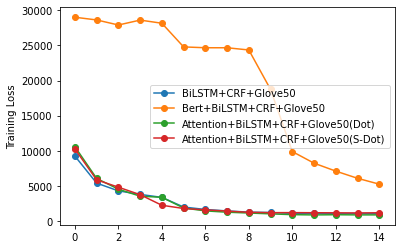

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(15)
plt.plot(x, Loss_base[:15], label = "BiLSTM+CRF+Glove50", marker='o')
plt.plot(x, Loss_bert[:15], label = "Bert+BiLSTM+CRF+Glove50", marker='o')
plt.plot(x, Loss_att2, label = "Attention+BiLSTM+CRF+Glove50(Dot)", marker='o')
plt.plot(x, Loss_att[:15], label = "Attention+BiLSTM+CRF+Glove50(S-Dot)", marker='o')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

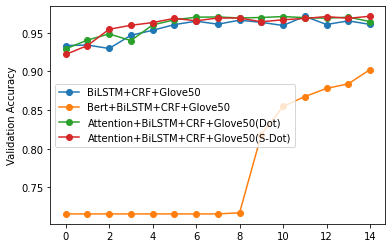

In [ ]:
x = np.arange(15)
plt.plot(x, acc_base[:15], label = "BiLSTM+CRF+Glove50", marker='o')
plt.plot(x, acc_bert[:15], label = "Bert+BiLSTM+CRF+Glove50", marker='o')
plt.plot(x, acc_att2, label = "Attention+BiLSTM+CRF+Glove50(Dot)", marker='o')
plt.plot(x, acc_att[:15], label = "Attention+BiLSTM+CRF+Glove50(S-Dot)", marker='o')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

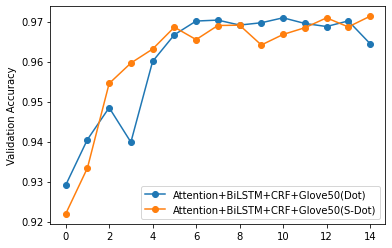

In [ ]:
x = np.arange(15)
plt.plot(x, acc_att2, label = "Attention+BiLSTM+CRF+Glove50(Dot)", marker='o')
plt.plot(x, acc_att[:15], label = "Attention+BiLSTM+CRF+Glove50(S-Dot)", marker='o')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

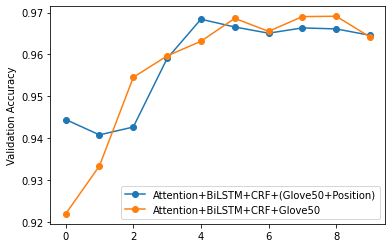

In [ ]:
x = np.arange(10)
plt.plot(x, acc_pos, label = "Attention+BiLSTM+CRF+(Glove50+Position)", marker='o')
plt.plot(x, acc_att[:10], label = "Attention+BiLSTM+CRF+Glove50", marker='o')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
checkpoint = torch.load('./model/att_bilstm.pt')
#checkpoint = torch.load('./model/bert.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
ids = []
predictions = []

with torch.no_grad():
    for i, sent in enumerate(ds_test):
        sent_index = to_index(sent, word_to_ix)
        sent_in = torch.tensor(sent_index, dtype=torch.long).to(device)
        output = model(sent_in)
        pred = [k for idx in output[1] for k,v in tag_to_ix.items() if v==idx]
        pred = ' '.join(pred)
        predictions.append(pred)
        ids.append(i)

In [ ]:
tmp_dict = {'ID': ids, 'Predicted': predictions}
submit = pd.DataFrame(tmp_dict, columns = ['ID', 'Predicted'])
submit.head()

,ID,Predicted
0,0,O
1,1,O O I-LOC O O O O I-LOC O O O O
2,2,O O
3,3,I-LOC O I-LOC I-LOC I-LOC O
4,4,I-LOC O O O O O I-MISC I-MISC O O O O O O O I-...


In [ ]:
df_test.head()

,Sentence,NER
0,-docstart-,NaN
1,"soccer - japan get lucky win , china in surpri...",NaN
2,nadim ladki,NaN
3,"al-ain , united arab emirates 1996-12-06",NaN
4,japan began the defence of their asian cup tit...,NaN


In [ ]:
idx = []
one_pred = []
c = 0
for i in range(len(submit)):
    predicted = submit['Predicted'].iloc[i]
    one_pred += predicted.split(' ')
    for j in range(len(predicted.split(' '))):
        idx.append(c+j)
    c+=j+1
    
tmp_dict = {'ID': idx, 'Predicted': one_pred}
submit_46 = pd.DataFrame(tmp_dict, columns = ['ID', 'Predicted'])

submit_46.head(10)

,ID,Predicted
0,0,O
1,1,O
2,2,O
3,3,I-LOC
4,4,O
5,5,O
6,6,O
7,7,O
8,8,I-LOC
9,9,O


In [ ]:
submit_46.to_csv('submit_46_2.csv', index=False)